In [24]:
from ecosap.ecopro import SpectralComparison
from pathlib import Path
import sqlite3
import pandas as pd
import pickle
import numpy as np

# Calculate PSD's

In [ ]:
conn = sqlite3.connect('../results/results.db')
cursor = conn.cursor()

unique_folders = pd.read_sql_query("SELECT DISTINCT folder FROM audios", conn)
unique_folders = unique_folders['folder'].tolist()

AUDIOPATH = Path('/Users/davidluna/Documents/Audios/compare-recorders/splitted/')

# GetPSD is a class that calculates the PSD of a signal
# and returns the PSD and the frequencies

for x, xfolder in enumerate(unique_folders):
    for y, yfolder in enumerate(unique_folders[x+1:]): 
        print(f'{xfolder}-{yfolder}')
        folder_x = pd.read_sql_query(f"SELECT path FROM audios WHERE folder = '{xfolder}'", conn)
        folder_x = folder_x['path'].tolist()
        folder_y = pd.read_sql_query(f"SELECT path FROM audios WHERE folder = '{yfolder}'", conn)
        folder_y = folder_y['path'].tolist()

        spec_df, f  = SpectralComparison().transform(folder_x, folder_y)
        # Save the PSDs in the database
        for ind,row in spec_df.iterrows():
            
            cursor.execute("INSERT INTO spectral_comparison (psd_x, psd_y, csd_xy, freq, folder_x, folder_y, n_audio) VALUES (?, ?, ?, ?, ?, ?, ?)", 
            (pickle.dumps(row.sxx), pickle.dumps(row.syy), 
            pickle.dumps(row.sxy), pickle.dumps(f), xfolder,
            yfolder,ind))
        conn.commit()    
conn.close()


# Calculate Coherence

In [207]:
def getComparableRange(freq, coh, window_size=10):
    if np.max(freq) < window_size:
        raise Exception('Window size is bigger than the array size')

    if isinstance(coh, list):
        coh = np.array(coh)
    
    if isinstance(freq, list):
        freq = np.array(freq)

    ws_coh = []
    threshold = np.median(coh)
    for i in range(0, int(np.max(freq)), window_size):
        wcoh = coh[np.logical_and(freq >= i, freq < i+window_size)]
        ws_coh.extend([wcoh.mean()]*len(wcoh))

    if len(ws_coh) < len(coh):
        ws_coh.extend([ws_coh[-1]]*(len(coh)-len(ws_coh)))

    mask = ws_coh >= threshold

    startFreqRange = []
    endFreqRange = []
    for i in range(len(mask)):
        if i==0:
            if not mask[i]:
                freq_val = int(freq[i]/window_size)
                startFreqRange.append(freq_val)
        else:
            if not mask[i] and mask[i-1]:
                freq_val = int(freq[i]/window_size)
                startFreqRange.append(freq_val)
            elif mask[i] and not mask[i-1]:
                freq_val = int(freq[i]/window_size)
                endFreqRange.append(freq_val)

    if len(startFreqRange) > len(endFreqRange):
        freq_val = int(freq[-1]/window_size)
        endFreqRange.append(freq_val)

    return np.array(ws_coh), np.array(startFreqRange), np.array(endFreqRange)

In [208]:
def range2text(startFreqRange, endFreqRange):
    text = ''
    for i in range(len(startFreqRange)):
        text += f'{startFreqRange[i]}k-{endFreqRange[i]}k \n'
    return text

In [219]:
conn = sqlite3.connect('../results/results.db')
cursor = conn.cursor()

unique_folders = pd.read_sql_query("SELECT DISTINCT folder FROM audios", conn)
unique_folders = unique_folders['folder'].tolist()
#unique_folders = ['SM04', 'G0059','G0096','G0001']

n = len(unique_folders)
freqComparison = [[None for _ in range(n)] for _ in range(n)]

for x, xfolder in enumerate(unique_folders):
    for y, yfolder in enumerate(unique_folders[x+1:]):
        try:
            spc_xy = pd.read_sql_query(f"SELECT * FROM spectral_comparison WHERE folder_x = '{xfolder}' AND folder_y = '{yfolder}'", conn)
            spc_xy['freq'] = spc_xy['freq'].apply(pickle.loads)
            freq = spc_xy.freq[0]
        except:
            spc_xy = pd.read_sql_query(f"SELECT * FROM spectral_comparison WHERE folder_x = '{yfolder}' AND folder_y = '{xfolder}'", conn)
            spc_xy['freq'] = spc_xy['freq'].apply(pickle.loads)
            freq = spc_xy.freq[0]
            xfolder, yfolder = yfolder, xfolder


        spc_xy['psd_x'] = spc_xy['psd_x'].apply(pickle.loads)
        spc_xy['psd_y'] = spc_xy['psd_y'].apply(pickle.loads)
        spc_xy['csd_xy'] = spc_xy['csd_xy'].apply(pickle.loads)

        Pxx = np.array([np.real(x) for x in spc_xy.psd_x]).mean(axis=0)
        Pyy = np.array([np.real(x) for x in spc_xy.psd_y]).mean(axis=0)
        Pxy = np.array([np.real(x) for x in spc_xy.csd_xy]).mean(axis=0)

        coh = abs(Pxy)/(np.sqrt(Pxx)*np.sqrt(Pyy))
        coh_mean = np.median(coh)

        
        coh_mean, startRange, EndRange = getComparableRange(freq,coh.ravel(), 1000)

        freqComparison[x][y+x+1] = range2text(startRange, EndRange)

        # Save the PSDs in the database
        cursor.execute(f"INSERT INTO comparable_frequency_range (start_freq, end_freq, folder_x, folder_y) VALUES (? , ?, ?, ?)", (pickle.dumps(startRange),pickle.dumps(EndRange), xfolder, yfolder))

conn.commit()
conn.close()
        

: 

# Graficar rangos comparables

/var/folders/10/tq6sylxx0k7_f72tbtgslkc00000gn/T/ipykernel_26764/2359943269.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(unique_folders)  # Ocultar etiquetas del eje x
/var/folders/10/tq6sylxx0k7_f72tbtgslkc00000gn/T/ipykernel_26764/2359943269.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(unique_folders)  # Ocultar etiquetas del eje y


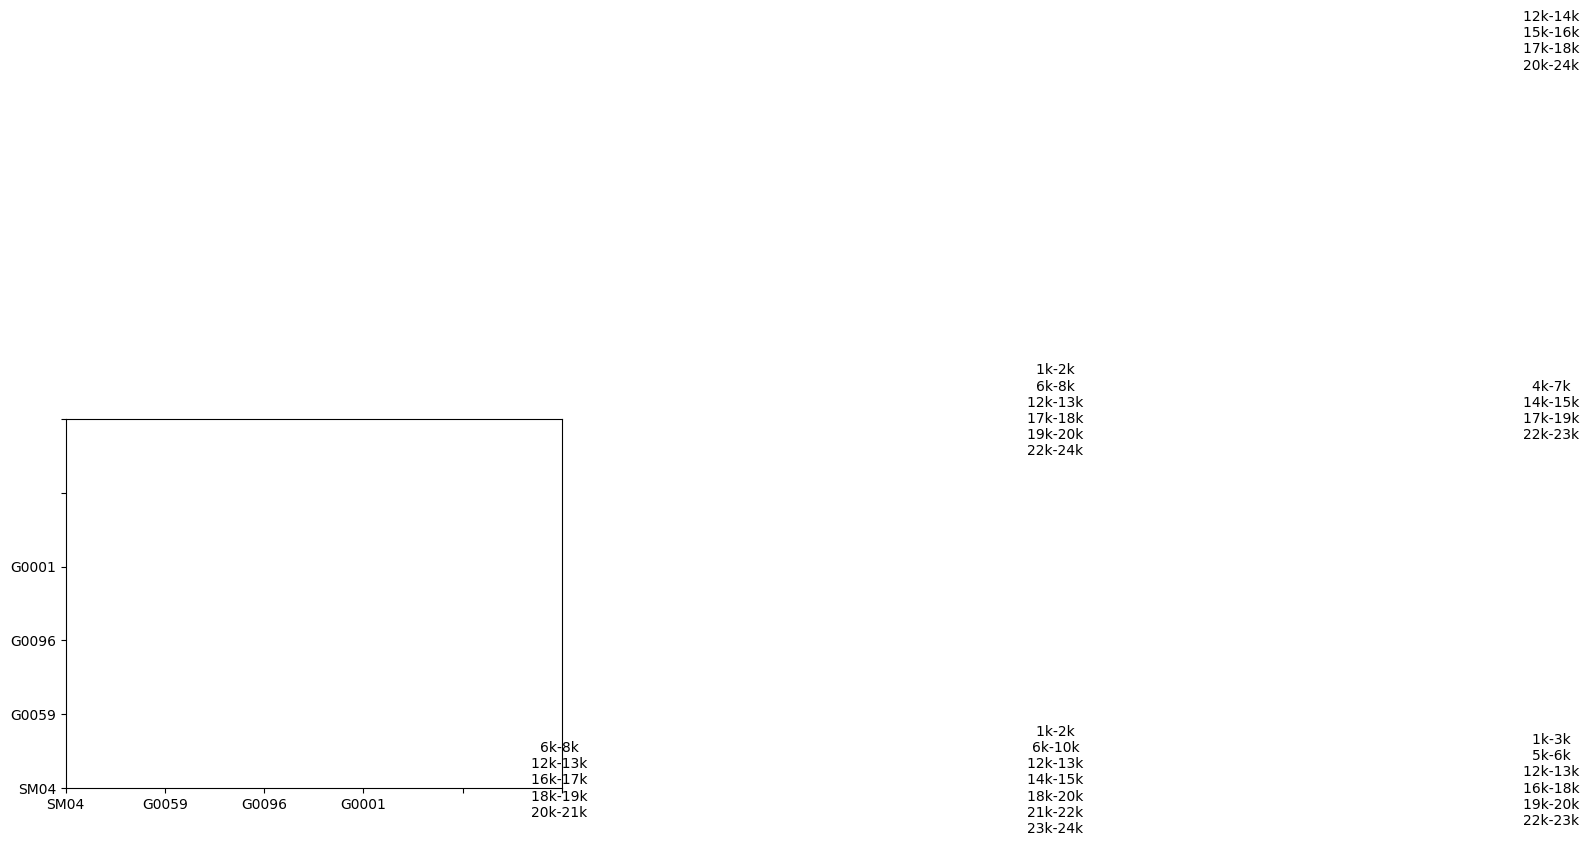

In [214]:

# Crear una figura y un eje
fig, ax = plt.subplots()

# Dibujar la matriz de texto
for i in range(len(freqComparison)):
    for j in range(len(freqComparison[i])):
        ax.text(j, i, freqComparison[i][j], ha='center', va='center', color='black', fontsize=10)

# Personalizar la apariencia de la matriz (opcional)
ax.set_xticklabels(unique_folders)  # Ocultar etiquetas del eje x
ax.set_yticklabels(unique_folders)  # Ocultar etiquetas del eje y

# Mostrar la matriz
plt.show()